In [1]:
import ecc_tools as tools
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info
from ecc_tools import distance_restr

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

# import pydca for plmDCA
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca.dca_utilities import dca_utilities

tools.hide_toggle()

## Using comprehensive software package for DCA
#### Author: Mehari B. Zerihun
article: https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/btz892/5645176
github: https://github.com/KIT-MBS/pydca
* mean field and pseudoliklihood methos
* several utility functions
    * MSA triming functions
    * Contact Map Plotting Functions

In [2]:
# Read in Protein structure
data_path = '../Pfam-A.full'
pfam_id = 'PF00186'
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

# Pre-Process Structure Data
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures: ',npdb)

# Print PDB array 
#print(pdb)
#print(pdb[0])

# Create pandas dataframe for protein structure
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
#print("pdb ids:\n",df['id'])
#print(df.head())

ipdb = 0
print('Referene Seq: ',int(pdb[ipdb,1]))

from data_processing import data_processing
from data_processing import write_FASTA

#------------- Data Processing ------------------#
s0,cols_removed,s_index,s_ipdb = data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)
# s_index - key for original indices after column removal during processing
# s_ipdb - new index for ipdb after bad sequence removal
#------------------------------------------------#

print(s0.shape)
print("Reference Sequence (shape=",s0[s_ipdb].shape,"): \n",s0[s_ipdb])
#print("Removed columns: ",cols_removed)


FASTA_data_outfile, FASTA_ref_outfile = write_FASTA(s0,pfam_id,s_ipdb)

#print(np.array(trimmed_data).shape)
#print(len(trimmed_data[0][1]))
#print(len(trimmed_data[5][1]))
tools.hide_toggle()

number of pdb structures:  372
Referene Seq:  69
tpdb is now  56
(6734, 137)
Reference Sequence (shape= (137,) ): 
 [ 7 15  6  7 17 10  2  3 11 14 17  8  2 11 14  9 12  6  9 12  0  2  9  0
 19  8 14 17 10  5  6  0  7 17  8  4  3  0  7  5 14 12 12  5  2 11 17 17
 17 16 14 11 14 15  4 14 12  3  5  1  9 17  9  6 15  9  3  3 17  8 13 18
  7  0 15 14  2  3 17  4  7  7  0  3  9  4 14  0 16 10 12  7 17  2 14  9
 19 17  8  7  4  0 15  4 12  5 16  4 19 12  7 15  2  2  3 18  3  7 17 15
 19 16 12  5  5  3  8 11 12 19  3  6  0  4  7  7 19]
Reference Sequence number:  56
Reference Sequence (shape= (137,) ):
 ['I' 'S' 'H' 'I' 'V' 'M' 'D' 'E' 'N' 'R' 'V' 'K' 'D' 'N' 'R' 'L' 'P' 'H'
 'L' 'P' 'A' 'D' 'L' 'A' 'Y' 'K' 'R' 'V' 'M' 'G' 'H' 'A' 'I' 'V' 'K' 'F'
 'E' 'A' 'I' 'G' 'R' 'P' 'P' 'G' 'D' 'N' 'V' 'V' 'V' 'T' 'R' 'N' 'R' 'S'
 'F' 'R' 'P' 'E' 'G' 'C' 'L' 'V' 'L' 'H' 'S' 'L' 'E' 'E' 'V' 'K' 'Q' 'W'
 'I' 'A' 'S' 'R' 'D' 'E' 'V' 'F' 'I' 'I' 'A' 'E' 'L' 'F' 'R' 'A' 'T' 'M'
 'P' 'I' 'V' 'D' 'R' 'L' 'Y' 'V'

FSIIVMGENREKKNKLLHIPEDLKNKKTTGKTVIKFESIGKAPDRNIVLSRTFGQEEKEIEVYDNFDDVIKYYDTDEEVFIIEDVYQTALKYVKKLYIYIKSDKEAAYFEIDYREWGMREEKQFE------------
ITIIAAAENNAKDNDLVHLPDDFKRKELSGHHIIKFESLPKAPNTHIIITRKEDYKAVNCIVAHSLETALKASVSDPQPFIIGEIYKQAMDIADKIELRVHATVEATFFEIDPQEWELTAQEHHLDRHKYSFSYLTY
LNCIVVSQNMGKNGDLPPLRNEFKYQRMTQNLVIKWFSIPRPKDINIVLSRELKEPPQGAHLAKSLDDALDL-ADKDMIWIVSSVYKEAMNQPGRLFVRIMQEFESTFFEIDMEKYKLLPEYPGEEEKGIKYKFEVY
IHLILRARNGVHQNKMPHIPADLRHKRLINHPMIKFESLPGLPDPHIVLTHNMNWQAEGCEVAHNLDQAIEIALRYSRIAIIAQIFKQSWSLADYIELEIEKDYTGTYVLPDMSGFSLESQQDYDESGQPAFCFKRF
-----MSRNRVRNNKLPYLPGDLRYKQAMGKPIIKWDSIGRPPGMNVVISRNPEWEAPGTVAAESLEDALQA---EDEVMIIGQIYAEVLPMVDRIYIQVHAEVDGAFFEVNWEEWEELGREDFSDNNPYDYSFVVY
ISMIWMGANGVKDNDMPHLPRDFAFKSEFGKAMLKWESLGKPKDTSIIITRDRSYAPEGAKVVHTVEEALAEGGKGDELMIIAEIYRMFLPYADKLIVRIEHEFEGTKFEVEWSEWTEISNTPGIEKNPYDYRFYVY
ISLIAISKNLVYKNKIPYLPEDLKWKQKINKNIILWESIKKPPGKNIVISSNEI-KQEGIIWADSISNAI-ISAQYQEIMIIAKIYKEMLQYANKLYLHIDIDIVGAYFEYKLPLWKTLFRKKNTKPNPYNYSFEIL
-QVVVATKDMGKDGKLPKLPSDLKFKDVLKNAVI

IVAIAAAENNAKDNDLLHLPDDFKRKKLTGHPIIKFESFPKPPNKHIVITRDKDYTIDNCVVVHSLESALELTKKEDLAYIIGEIYKLALEYTHIIELRVHAEFDATYFELNKENWEVILEEYHPDKHKLDFTYITY
-EIIVVDENYGKDGDLLHLSEDLKRKAMVGNIIVKYMSFPRPPDENLIITHHPE-NYPGIKCFTGVGEFLEYSKTAKPIFVLGSVYEQLLPYCEKAHIKILHSFEATFFNLDNPEWEKENEEEIV-GEKYPFKYVTY
IHIIAHDKNRGRNNDLPHLSQDLQHKRTLGKPVLNYDSILKPPHLNIVITSQPLINFSEVKTARSIDEAMAAINLNEELFVIAQLYKATLPIAEKLYIEIDGVFDCTYFEY-KNMFRLVSQQEGI-ENNLHFTWNEY
-NLIVVDENWANRNKLLSIPADMKFREMKGNVVVKMESFPQPKKTNIVLSRDESYQVKDAVVVHSLEELLEQLKSFESIYVIESIYRMLLPYCKEAYIRIRHSYAATYFDLDAPEWELEDESEEQTYFDLEYVFTRY
---MWEDLDGGKDNTLPHVPADMRHKQVMGQPVIRYESIGRPPHENIVLTHRDL-MIPGVTVVHDKAALMGLLDRLENACVIAGVFDALLPWATTLERVINGHYHGTKMPVDYSRWHLLDRQTVDGA----------
IVFIVVADNGVRDNAMPHLRSDLQRKQLLNKPVIKYLSIGKPPKTNIVVTRDPGFRAAGTVVVPSLDAAYDILRRGSEIMVIAEIFQQWMPRATRLEIHVHAEPDGTFLRFEMAEWQEVARTRPAPEDSADFSYATY
--MIAVGRNGVDGETMPHLSEDLKFKRTMGHPMVRFDSMG-APGRSVVVTRSRDWSHDGVEVAHSVEEALDLVAGDGEVFVVGEVYRLALPYVARLVIEVDQSPEGVTFEIDPEDWVETSREART------------
VALIWQAHDRVVDGVMPHLPEDLRHRALGTHPVI

VSLVAMDENYGKDNQLLHLPADLKHKAIMGKPIINFDSIGKPPGRNIVLSRQIKA-IEGVEVVDSLNKAVV-IAEAPEVMIIASIYEQAISIASQLYLVIHHRFSAVFFKFDPRQWVVKSENFYSEKNRYDMTFYHY
--LIWQSTSGVRGGDIPRVPEDLSHKRIMGHTVVRWDSLPRPPGRNVVLSRQPGFVAEGAEVVGSLEDAL---TGPEDTWVIEQIYTLALPRADRCEVEVDVDLDDALAPLD-ETWQGDVGEWQVSRSGLRYRFHSY
-HLIVVDKNWAKNNKLPSIPADMKYRETKGNIVIKLESFPQPKNVNIVITNNKDYKVKDAVVVHSIEEAIEEAKKYGTPYVIESIYRAMLPYCDTALIKIDHAFDATYFNLDEEEWEMTKISEEQTCFDLEYYFTVY
ITLIAYAAHRCINNSMPHLPEDFAFKQYLGKPVVKWESLPKPPGRNIVISRQAGYIAEEAEIAASLREAFEKCLHAEEIIVMEQIYRQSLPFATDLRIEVDLDVQGAFFEISRKEWEEVSREVYQSSKNIRYAFVHY
--VIAFASSRGVRGGLPRLPADLRRKRLTGNAVINWQSIPRPPGINIVLTRDPSIDSTSVKVASSLTHGLQLEDQEDRVFVIEKVYADALDECHVLHLRVLDEPDCAFFDVDWSQFMEVDASDPMVENDTRFEFLTY
--IVAAGPHRGLNNQLPRIPADLKHARVTGHAVIKWESLPRPPELNVVLSRQDTLVLDGVLLAKSLDEAFQQCRNHSKVFVMAEIYQQALEYVNEVIMEVNYQGKCAFFELNEDEWERDYYYDQETGNDLEYTFYKY
ISMIAYARNRVRDGAMPHLPNDLKHKEVTGQTIVKFESLGRPPNRNVVLTRRRDFAPPGVDVVHSVEEVLA----LGDVIIFAELYRQFMDVADRLYIEIDMEAEGTFFEWDRDAFTLVWKREGTEQNPVPHTFYLY
VSLIWMDHNRLCNNALPQLPADMAWRKNMGKPIL

VGLIWQSTSGVRDGGIPRLPEDQARKELMGHTVVLWESLPRPPGRNVVLTRRADYAAEGADVIADLDDAL----TDESTWVIAEVYAAALPVATRCEVEVEPRYDGAVAVLD-EGWVGAAGEWQTSRSGLRYRFYSY
IGMIWQARGGVADGSMPHLPEDLKHRRTSGSPVVRWDSFPRPPGTNIVITRDDALELPGAVRARSLPEALELAATEGTTWVIGSIYADAIEVAELLVVEIDLEVDGTRAAI-PEDFTLTSADPAAHEGGTRYRMLTY
VSLVWQARDRVAGGRLPHLPEDLRLKELSGGTVVRWESLPRPPGRNVVLTRDPAWAADGAERAGSVADVLA---TAPGCWVIAAIYTAFLPHAGRLVVDVDLAVDGTRAALDG-RWQPVTRSPGEATTGLRYAVTEY
LSLIVRARNGAKDGDIPSLPEDLKFQRETGGAIIRWESLPKPKNLNIVVSSA---DIDGVHVARDPQAALGYCAAERRVYGIEGIYRALLPLADRLLVEVDVEIDAAFFDFDPNEWIE-------------------
LGAIWQTDAGIRAGDMPYAPEDLAHKKVLGAPVIRWESFPRPPGTNIVISRSVTEAEDGALWVPSLDAALDTATDAVDAWIIGSVYAEALSRADTVERLVYNEITGTRAELQ-------------------------
LTLIVRARNGVRNNQLPRLPEDLAFKRTMGAPIVKHESIGRVPGRNIVVTRDTERRFDGCDTVTGLADALALAERDSEVFLIAELFREGWPMAQKLILEIDADFEGISIAPDAAVWKELSRETHRAPNDFDYSFVVY
-NLIVVDRNWAKDNKLLSIPDDMKFRETTGKVVVKLESFPKPKNVNIVLTRDPNYTVKDAIIVHSKEELDKELEKYDDIYVIESIYRMLLDDCNRAFVYVDYSYDATYFNLDEPEWKMVEESEEQTYYDIEFYFRKY
ISIIVVSKNNVNNGVIPKIKGEQKRKELTGKTII

LVSVALSENRVRDGELPSLPADRAQRALADAPVVRFDSMRRDPGAQVVVSRSRDVDASTARVAGGVSDALSALSAVDVAYVLGVVYHLFQPHVSRMVLHVPGAYEGSTFAWDETAWTVAREEPR-------------
LIAVWQARNGVKDQKMPHLPNDFQFRSQMNHKIVKFEGMGKPPDQTYILTRSESIAISSVELIHAIDAILELAKKE-DVYIIKQIYQSFWPYLDELRVYIDHAIAGTVMNPDLSDFHSAAEIKGADKNPYPHRFIEY
ITMIWMGRNGVKDNGMPHLPRDMAFKEQMGKPVVKWESFGKPKDTNIVMTRDSEYTSQDAQIIHSLEEALEYANNQ-ELMIIAQIYEKWLPYADRLLVRIDEDFEGTVFDIDWTCWSLSEEIPGVDKNPYDYRFSIY
ITLIACADNGCIDNTMPHLPEDFAFRTYSGKPVVKWESLPKPPNRNIVITRQTGYVAEGAETVSGLQEALDLCPEAEEIIIMAQIYTQALPQATDLRIEVHLNVEGAFFTFNRAEWQETARKSHTAANGIRYSFVHY
VSIIAVDRNLGFQNKLLWLPNDLKRKALTGNTIIKFESLPGAPNRNVVLSSNPATLCPGAEVFPTLEAALQSCQPEEQVYIIASVYKQAMPLADMLCLEIAEAPQVAYFAVDLAIWHEKSRESHLEKHPCSYAFVDY
--MIAAGENNEKNGEMVHLPDDFKRKALTGHHIIKFDSFDKPPNTHIVITRDKNYTSDHAIIVHDMDTALAAVGNDANPFIIGEIYSLGMSYANKIELRVHGTFDAAYFRIDKSKWKLVNSTSHGERHKYSFDYETW
--VVASGLSRGINGQLPSISEDLKFSKISNNALIKWDSIGRPKNKIVVISSSLPDEADNVIVFRNLEDSIKLMNDDENIFVCESIYRDALKFVDRIYLRVAEDIEGTYFEI-PETFLPVYRSQTFDTKNISYDFMVF
LSLIALAENRVIDNSMPHLPGDFKYKATLGKPII

LGLVWQSTSGVRGGDIPRLPEDLARKQVLGHTVVRWDSLPRPPGRNVVLSRQAGFTADGAQVVRSLEQAI----NGDDTWVIGEVYALALPLATRCEVEVDIDLDAALAVLD-EDWVGETGEWLVSSGGLRYRFHSY
LTLIVRARNGVRDNQLPRLPEDLAFKRTMGAPIVKHQSIGRVPGRNIVVTRDAGRRFEGCDTVPGLEEALEVAARDKEVFLIAELFRKGWELAQKLVLEIDADFEGISIAPDPAVWTEISREKHRAPNDFDYSFVVY
ISIISVAENRVDKNSLPHLPADFKYKEILGKPIVNFKSIGKPPDKNIILTNDLSYIPEGCFVARSIDELLQMVKNEDEVMVCESVYKQFLPLANRLYLFIHHNFEGAYFEFDINNWKEVKRTDHKDKNKFDYSFAIL
IVLIAVAANGVRDGEMPHIPADLQQKHRMGHPVIRYETIPEPPGTSIVLSSQSRDVPTDVILVHSITSAINALE-RETVYVAGGVYEQFLPLADRLRLELHDEYDGTRFSWDSSTWKELTRENHE-----TFDFVTY
IVLIVVAENGVAAGAIPRLKSDMQRKALMGRPIVKFVSFPRPPGTNIIVTRDAAFRAAGAIVTHSIAEALDALRRSAEIAIVAEIYTATLPLTDRLEIEVHARPPGTLFAIDPAQWEEVARERHAPDDQADFSYVTY
LNLVVMCNNRGINGQLPRLRGDMNFKKISENAVIKWFSIPRPANINVVLSREMKDSPDGAHISRSLEDALPPLSDKESLFVISAIYEMALPQCHRIYLRVMADFECTFLDFAQDKFAMV------------------
--LIVMDAEMGKGGGLPQLKEDMQRMRLSKNVIVKWQSIPRPKNINIVLSRTLEEHEENLIICNDISRVSEIVSSLEKIWNIKEIYQQALDLVQELYVKIHKSFETVKLGISWENFEEDAEKREGTESDTTYTFH--
LQIIVCSKNRGLNNSIPKLPGDMTFRKLSENAIL

We import pydca. We Import and process MSA file and write the processed MSA data to an output file MSA_PF00186.fa in FASTA format. Next we carry out DCA computations using the processed MSA saved in MSA_PF00186.fa

### DCA Computation Using Pseudolikelihood Maximization Algorithm (plmDCA)

In [3]:
# Compute DCA scores using Pseudolikelihood maximization algorithm

plmdca_inst = plmdca.PlmDCA(
    FASTA_data_outfile,
    'protein',
    seqid = 0.8,
    lambda_h = 1.0,
    lambda_J = 20.0,
    num_threads = 10,
    max_iterations = 500,
)
#print("properties of plmDCA object: \n",dir(plmdca_inst),"\n\n")

sorted_DI = plmdca_inst.compute_sorted_DI()

N = plmdca_inst.sequences_len
B = plmdca_inst.num_sequences
print("sorted_DI (list) has shape: ",np.array(sorted_DI).shape,"\nRows: all combinations of sequence postitions ie sequence len choose 2 ")
print("num sequences = %d , sequences len = %d\n\n"%(B,N))

print("Print top 10 pairs")
for site_pair, score in sorted_DI[:10]:
    print(site_pair, score)


# compute DCA scores summarized by Frobenius norm and average product corrected
plmdca_FN_APC = plmdca_inst.compute_sorted_FN_APC()
tools.hide_toggle()

sorted_DI (list) has shape:  (9316, 2) 
Rows: all combinations of sequence postitions ie sequence len choose 2 
num sequences = 6734 , sequences len = 137


Print top 10 pairs
(10, 105) 0.10276888434031166
(28, 43) 0.08091137607854659
(44, 60) 0.07895035303040722
(117, 120) 0.06677868893274606
(38, 39) 0.06336487049474573
(7, 100) 0.060083644653192284
(11, 12) 0.056827309399624826
(65, 88) 0.04908178458101783
(30, 79) 0.044476277932278034
(24, 27) 0.042469044965696166


## PlmDCA for Protein PF00186. 
* we used the data processed sequence alignment (our version) and not the trimmed MSA data from pydca
* We also set the values of optional parameters. 
* pydca can also be used to compute DCA scores from the Frobenius norm of the couplings by calling the compute_sorted_FN_APC() method on plmdca_inst
    * This action returns the average product corrected (APC) DCA scores. Let us print the top five site pairs and their DCA scores.

In [4]:
# Generate Direct Information matrix
DI = np.zeros((N,N))
DI_ver= np.array(sorted_DI)
for coupling in sorted_DI:
    DI[coupling[0][0],coupling[0][1]] = coupling[1]
print("Calculated DI: (shape, matrix)\n",DI.shape,"\n",DI)
np.save("plmDCA_DI_%s.npy"%(pfam_id),DI)

tools.hide_toggle()

Calculated DI: (shape, matrix)
 (137, 137) 
 [[0.         0.00230717 0.00305386 ... 0.00159148 0.00123733 0.0008116 ]
 [0.         0.         0.00452925 ... 0.00169855 0.00428189 0.00236509]
 [0.         0.         0.         ... 0.00191594 0.00165854 0.002083  ]
 ...
 [0.         0.         0.         ... 0.         0.00383925 0.01452482]
 [0.         0.         0.         ... 0.         0.         0.00126836]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## Visualization in pydca
* Need Reference Sequence to contain no gaps
    * This is an option in data_processing (ie find and replace all '-')
    * Have not tested accurace of methods with randomized replace ment of gaps


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


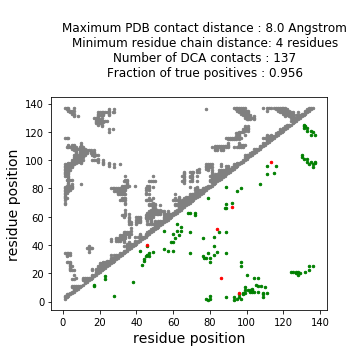


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


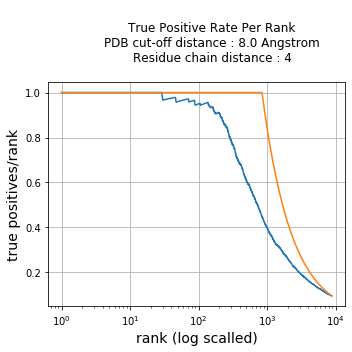

In [5]:
# compute DCA scores summarized by Frobenius norm and average product corrected
plmdca_FN_APC = plmdca_inst.compute_sorted_FN_APC()

plmdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = FASTA_ref_outfile,
    sorted_dca_scores = plmdca_FN_APC,
    linear_dist = 4,
    contact_dist = 8.0,
)

contact_map_data = plmdca_visualizer.plot_contact_map()
tp_rate_data = plmdca_visualizer.plot_true_positive_rates()